In [58]:
import pandas as pd
import itertools
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt
import numpy as np

#load data labels and RDkit fingerprints
#naively assign data for all proteins to one giant array
f_truth = pd.read_csv('TMPRSS2_processed.csv')
f_tmpss11d = pd.read_csv('TMPRSS11D_processed.csv')
f_st14 = pd.read_csv('ST14_processed.csv')
f_tmprss6 = pd.read_csv('TMPRSS6_processed.csv')
f_klkb1 = pd.read_csv('KLKB1_processed.csv')
fp_dark=np.load('DarkChemicalMatter_morgan_fingerprints.npz')
fp_dark=fp_dark['fps']
fp_tmprss11d = np.load('TMPRSS11D_morgan_fingerprints.npz')
fp_st14 = np.load('ST14_morgan_fingerprints.npz')
fp_tmprss6= np.load('TMPRSS6_morgan_fingerprints.npz')
fp_klkb1=np.load('KLKB1_morgan_fingerprints.npz')
fp_truth=np.load('TMPRSS2_morgan_fingerprints.npz')
f_truth= f_truth.assign(cid= [int(lkey) for lkey in list(fp_truth.keys())]) #reassign 0 cids
#TODO: use combined dataset for training with xcorr vals
#method 1: try to concat all datasets together
features=pd.concat([f_tmprss6, f_klkb1, f_st14, f_tmpss11d, f_truth]) #concat datasets in order of closeness to tmprss2, from Doug's analysis
features.drop_duplicates(subset='cid', keep='last') #prioritize activity from tmprss2 dataset

,cid,acvalue,activity,smiles
3,71460447,8.900,Active,C1=CC(=CC(=C1)S(=O)(=O)NCCC(=O)NCC2=CC=C(C=C2)...
4,71458616,7.600,Active,CC(C)(C)OC(=O)C1=CC=C(C=C1)NC(=O)CCNS(=O)(=O)C...
5,71462144,16.300,Active,C1=CC=C(C=C1)C[C@@H](C(=O)NCC2=CC=C(C=C2)C(=[N...
6,71454977,25.300,Active,C1=CC=C(C=C1)COC[C@@H](C(=O)NCC2=CC=C(C=C2)C(=...
7,71454982,22.000,Active,C1=CC(=CC=C1CNC(=O)CNS(=O)(=O)C2=CC=C(C=C2)C(=...
...,...,...,...,...
87,90666144,0.013,Active,CNC(=O)NCCC1CCN(CC1)C(=O)[C@H](CC2=CC(=CC=C2)C...
88,90666145,0.011,Active,CNC(=O)NCCC1CCN(CC1)C(=O)[C@H](CC2=CC(=CC=C2)C...
89,90666146,0.003,Active,COC1=CC(=C(C=C1)C2=CC(=CC=C2)S(=O)(=O)N[C@@H](...
90,90666147,0.005,Active,C1CCC(CC1)NC(=O)NC2CCN(CC2)C(=O)[C@H](CC3=CC(=...


In [4]:
#basic block for fingerprint
#borrow code snippet from Datasets_1_Prepare_PubChem_Datasets.ipynb
#CURRENT ERROR WHEN STANDARDISING: ''Unkekulized atoms: 0 2 3 4 6''
#from rdkit import Chem, DataStructs
#from molvs import Standardizer 
#from rdkit.Chem import AllChem, SaltRemover, QED, rdMolDescriptors
#s=Standardizer()
#remover=SaltRemover.SaltRemover()
#m=[Chem.MolFromSmiles(f_dark['smiles'].iloc[i]) for i in range(len(f_dark))]
#m=[i for i in m if i] #remove failed parses
#standardise and remove salt
#ERROR IN STANDARDISATION
#m=[s.standardize(im) for im in m]
#m=[remover.StripMol(im) for im in m]
#m2=[Chem.MolFromSmiles(f_truth['smiles'].iloc[i]) for i in range(len(f_truth))]
#m2=[s.standardize(im) for im in m2]
#m2=[remover.StripMol(im) for im in m2]

RDKit ERROR: [07:56:16] SMILES Parse Error: syntax error while parsing: [S](=O)(=O)(N(C(=O)C)|[Na+])C1=CC=C(N)C=C1
RDKit ERROR: [07:56:16] SMILES Parse Error: Failed parsing SMILES '[S](=O)(=O)(N(C(=O)C)|[Na+])C1=CC=C(N)C=C1' for input: '[S](=O)(=O)(N(C(=O)C)|[Na+])C1=CC=C(N)C=C1'
RDKit ERROR: [07:56:27] SMILES Parse Error: syntax error while parsing: [K+]|OC(=N[S](=O)(=O)C1=CC=C(N=NN(C)C)C=C1)CC
RDKit ERROR: [07:56:27] SMILES Parse Error: Failed parsing SMILES '[K+]|OC(=N[S](=O)(=O)C1=CC=C(N=NN(C)C)C=C1)CC' for input: '[K+]|OC(=N[S](=O)(=O)C1=CC=C(N=NN(C)C)C=C1)CC'
RDKit ERROR: [07:56:29] SMILES Parse Error: syntax error while parsing: [K+]|OC2=CC(=O)N(C1=CC=C(F)C=C1)C(=N2)SC
RDKit ERROR: [07:56:29] SMILES Parse Error: Failed parsing SMILES '[K+]|OC2=CC(=O)N(C1=CC=C(F)C=C1)C(=N2)SC' for input: '[K+]|OC2=CC(=O)N(C1=CC=C(F)C=C1)C(=N2)SC'
RDKit ERROR: [07:56:32] SMILES Parse Error: syntax error while parsing: [Na+]|OC2=C(C(CC(=O)C)C1=CC=CC=C1)C(OC3=CC=CC=C23)=O
RDKit ERROR: [07:56:32] SM

In [34]:
print(list(fp_dark.keys()))

KeysView(<numpy.lib.npyio.NpzFile object at 0x11dbe16d0>)


In [52]:
#morgan fingerprints
#fp_dark=[AllChem.GetMorganFingerprintAsBitVect(m[i], 2, useChirality=True) for i in range(len(m))]
#fp_truth=[AllChem.GetMorganFingerprintAsBitVect(m2[i], 2, useChirality=True) for i in range(len(m2))]

In [5]:
#ported from Prepare Pubchem datasets
#def fingerprint_to_np(fp):
#    bit_string = fp.ToBitString()
 #   return np.array([int(char) for char in bit_string], dtype=np.uint8)

In [53]:
#make np vector for dark data and save
#np_fingerprints_dark = {str(im): fingerprint_to_np(ifp) for im,ifp in enumerate(fp_dark)}
#np_fingerprints_truth = {str(f_truth['cid'].iloc[im]): fingerprint_to_np(ifp) for im,ifp in enumerate(fp_truth)}
#np.savez('../dumps/dark_fp.npz', np_fingerprints_dark)

In [31]:
features.head(5) #inspect data
fps_merged = []
ac_merged = []
activity=[]
cids=[]
datalabels=[]
#function to merge npz arrays
def merge_keys(in_xarray, in_yarray, in_y2array, in_fp, in_data, in_cids,datalabel):
     for i in range(len(in_fp.keys())):
            if not int(list(in_fp.keys())[i]) in in_cids:
                in_cids.append(int(list(in_fp.keys())[i]))
                acval=in_data.loc[in_data['cid']==int(list(in_fp.keys())[i]), 'acvalue'].iloc[0]
                active=in_data.loc[in_data['cid']==int(list(in_fp.keys())[i]), 'activity'].iloc[0]
                in_yarray.append(acval)
                in_xarray.append(in_fp[list(in_fp.keys())[i]])
                if active == 'Active':
                    in_y2array.append(1)
                else:
                    in_y2array.append(0)
                datalabels.append(datalabel)
     return in_xarray, in_yarray, in_y2array, in_cids, datalabels
            

In [32]:
#merge in order of similarity
fps_merged, ac_merged, activity,cids,datalabels=merge_keys(fps_merged, ac_merged, activity, fp_truth, features, cids,datalabel='tmprss2')
fps_merged, ac_merged, activity,cids,datalabels=merge_keys(fps_merged, ac_merged, activity, fp_tmprss11d, features,cids,datalabel='tmprss11d')
fps_merged, ac_merged, activity,cids,datalabels=merge_keys(fps_merged, ac_merged, activity, fp_st14, features,cids,datalabel='st14')
fps_merged, ac_merged, activity,cids,datalabels=merge_keys(fps_merged, ac_merged, activity, fp_klkb1, features,cids,datalabel='klkb1')
fps_merged, ac_merged, activity,cids,datalabels=merge_keys(fps_merged, ac_merged, activity, fp_tmprss6, features,cids, datalabel='tmprss6')

46899577
56677005
49835415
49835557
-1
49835508
49835606
49835507
49835556
56670171
56673691
46899736
56673692
49835559
-2
-3
56673693
-4
-5
-6
-7
-8
-9
-10
-11
-12
-13
-14
-15
-16
56683659
56683658
56666743
56663318
56659849
56663317
56666744
56677006
56659848
53379392
56683657
56680339
-17
-18
-19
-20
-21
-22
-23
-24
-25
-26
11584729
446605
44362312
44362395
71495974
71495976
90666140
71495975
90666141
71495977
89399327
71496201
90666142
71496089
90666143
71496202
50939649
71495381
71495660
71495659
71495661
71495467
25181493
44569813
44569811
71495466
90666139
71495766
71495765
71495561
71496204
50939651
71495468
71495560
71495559
90666144
90666145
90666146
90666147
-27
449051
56677008
56666745
56666746
56673694
56673695
56673696
56659850
49835506
56659851
56659852
56677007
49835505
11974
432298
411406
135435498
4735
126363
9895193
11578158
11570580
11664107
11569930
44413355
11678360
11570759
11607091
11534959
11614477
11513105
11642802
44413356
11664334
11563632
11570700
11577970


In [56]:
#append tmprss2 fingerprints
#for i in range(len(np_fingerprints_truth.keys())):
 #   if int(list(np_fingerprints_truth.keys())[i]) in cids:
  #      activity[cids.index(int(list(np_fingerprints_truth.keys())[i]))] = 1
   # else:
    #    fps_merged.append(np_fingerprints_truth[list(np_fingerprints_truth.keys())[i]])
     #   activity.append(1)

In [52]:
#convert to array
fps_merged=np.array(fps_merged)
activity=np.array(activity)
ac_merged=np.array(ac_merged)

In [60]:
#split train and test 
#half of tmprss2 active compounds to each set
import random
s=np.arange(len(list(fp_truth.keys())))
random.shuffle(s)
cut=41
test=s[0:cut]
train=s[cut::]

#add dark data. here we generate 1 test set that includes only data from TMPRSS2 dataset + negative examples
#and training data culled from all protein datasets, + negative examples that are not in the test set.
#the samples from TMPRSS2, and negative examples are sampled randomly to be about 50 percent.
s=np.arange(len(fp_dark))
random.shuffle(s)
cut=round(len(fp_dark)/2)
test_dark=s[0:cut]
train_dark=s[cut::]
X_test=np.concatenate((fps_merged[test], fp_dark[test_dark]))
X_train=np.concatenate((fps_merged[train], fps_merged[92::], fp_dark[train_dark]))
y_train=np.concatenate((activity[train], activity[92::], np.zeros([len(train_dark)])))
y2_train=np.concatenate((ac_merged[train], ac_merged[92::], np.zeros([len(train_dark)])))
y_test=np.concatenate((activity[test], np.zeros([len(test_dark)])))
y2_test=np.concatenate((ac_merged[test],np.zeros([len(test_dark)])))

In [ ]:
#UNUSED #NOT RUN 
def chars_to_ints(char_array):
    int_array=[int(s) for s in itertools.islice(char_array,1,len(char_array)-1,2)]
    int_array=np.asarray(int_array)
    return int_array
#NOT RUN

In [61]:
#split training and test set, keep random_state to be an integer for reproducibility
#train the forest (this can take a while)
#in the example, about 2/3 go to training and 1/3 go to test
#X_train, X_test, y_train, y_test = train_test_split(fps_merged,activity, test_size=0.33, random_state=39)
rf=RandomForestClassifier(verbose=2, n_estimators=100, random_state=111)
rg=RandomForestRegressor(verbose=2, n_estimators=100, random_state=111)
rf.fit(np.asarray(X_train), np.asarray(y_train))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 100


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.4min finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=111,
                       verbose=2, warm_start=False)

In [62]:
y_pred=rf.predict(X_test)
#print(y_pred)
#show probabilities; print(rf.predict_proba(X_test))
print(rf.score(X_test, y_test))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


0.999971310123223


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.5s finished


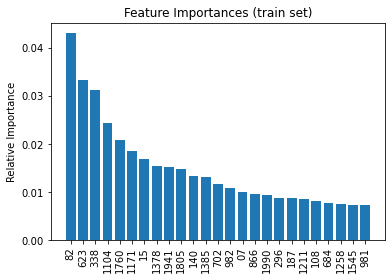

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     69670
         1.0       0.95      1.00      0.98        41

    accuracy                           1.00     69711
   macro avg       0.98      1.00      0.99     69711
weighted avg       1.00      1.00      1.00     69711



In [63]:
#get the index of the features (of RDkit fingerprint) that were important
importances = rf.feature_importances_
featurenums = np.array([str(x).zfill(2) for x in range(len(importances))])
indices = np.argsort(importances)[::-1][0:25]#get the 25 most important features
plt.title('Feature Importances (train set)')
plt.bar(range(len(indices)), importances[indices], align='center')
plt.ylabel('Relative Importance')
plt.xticks(range(len(indices)), featurenums[indices], rotation=90)
plt.show()
#output metrics
print(classification_report(y_test, y_pred))


In [79]:
nan_array=np.isnan(y2_train)
X_train2=X_train[~nan_array]
y2_train2=y2_train[~nan_array]

(array([], dtype=int64),)
70395


In [80]:
#now train the regressor, which is to predict the activity value itself
#takes about 1 hour to run
rg.fit(np.asarray(X_train2), np.asarray(y2_train2))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 100


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   52.2s remaining:    0.0s


building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 69.8min finished


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=111, verbose=2, warm_start=False)

In [88]:
X_test_reg=fps_merged[test]
X_train_reg=np.concatenate((fps_merged[train], fps_merged[92::]))
y2_train_reg=np.concatenate((ac_merged[train], ac_merged[92::]))
y2_test_reg=ac_merged[test]
nan_array=np.isnan(y2_train_reg)
X_train_reg=X_train_reg[~nan_array]
y2_train_reg=y2_train_reg[~nan_array]
rg=RandomForestRegressor(verbose=2, n_estimators=50, random_state=111)
rg.fit(np.asarray(X_train_reg), np.asarray(y2_train_reg))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    7.4s finished


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=50, n_jobs=None, oob_score=False,
                      random_state=111, verbose=2, warm_start=False)

In [85]:
y_pred_regr=rg.predict(X_test)
from sklearn.metrics import r2_score
print(r2_score(y2_test, y_pred_regr))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


-501.5690927457027


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.2s finished


In [89]:
y_pred_reg_noneg=rg.predict(X_test_reg)
print(r2_score(y2_test_reg, y_pred_reg_noneg))

-9.963546155078106


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


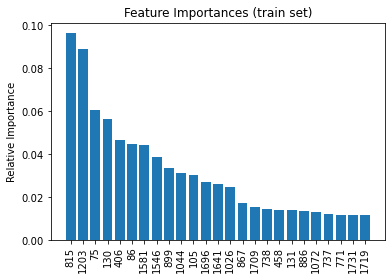

In [90]:
importances = rg.feature_importances_
featurenums = np.array([str(x).zfill(2) for x in range(len(importances))])
indices = np.argsort(importances)[::-1][0:25]#get the 25 most important features
plt.title('Feature Importances (train set)')
plt.bar(range(len(indices)), importances[indices], align='center')
plt.ylabel('Relative Importance')
plt.xticks(range(len(indices)), featurenums[indices], rotation=90)
plt.show()

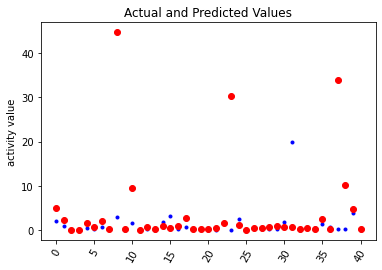

In [91]:
# Dataframe with predictions and dates
plt.plot(y2_test_reg, 'b.', label = 'actual')
# Plot the predicted values
plt.plot(y_pred_reg_noneg, 'ro', label = 'prediction')
plt.xticks(rotation = '60'); 

# Graph labels
plt.ylabel('activity value'); plt.title('Actual and Predicted Values');